# Generalising the updraft-downdraft coupling results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
import pandas as pd
from scipy.interpolate import interp1d
import sys
import shelve

import metpy.calc as mpcalc
from metpy.units import units, concatenate

from dparcel.thermo import (saturation_specific_humidity,
                            equivalent_potential_temperature)
sys.path.append('../convection_scheme')
from coupler import CoupledThermalGenerator

## Singapore sounding

In [2]:
file = ('test_soundings/48698 WSSS Singapore Observations '
        'at 00Z 01 Dec 2021.txt')
sounding = pd.read_fwf(file, usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure_raw = sounding[:2:-1,0]
height_raw = sounding[:2:-1,1]
temperature_raw = sounding[:2:-1,2]
dewpoint_raw = sounding[:2:-1,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], 5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)
generator = CoupledThermalGenerator(
    pressure, height, temperature, specific_humidity)

### $\epsilon_\mathrm{up} = 0.25 \text{ km}^{-1}$

In [3]:
# updraft parameters
i_init_up = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init_up], temperature[i_init_up])
     - specific_humidity[i_init_up]
)
l_initial = 0*units.dimensionless
l_crit = 2e-3*units.dimensionless
epsilon_up = 0.25/units.km

# downdraft parameters
i_init_down_min = np.min(np.argwhere(height <= 4000*units.meter))
i_init_down_max = np.max(np.argwhere(height >= 500*units.meter))
i_init_down = range(i_init_down_min, i_init_down_max+1, 2)
z_init_down = height[i_init_down_min:i_init_down_max+1:2]
i_precip_top = np.argmin(np.abs(
    np.atleast_2d(height) - np.atleast_2d(z_init_down + 2000*units.meter).T
), axis=1)

# shared parameters
w_initial = 0*units.meter/units.second
epsilon_down = np.arange(0.05, 0.601, 0.01)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [4]:
%%time
downdrafts = np.zeros((z_init_down.size, epsilon_down.size), dtype='object')
total_precip = np.zeros(z_init_down.size)*units('')
n_calc = epsilon_down.size*z_init_down.size
n_done = 0

updraft = generator.updraft(
    i_init_up, t_pert, q_pert, l_initial, w_initial,
    epsilon_up, dnu_db, drag, l_crit, basic=True)

for i in range(z_init_down.size):
    total_precip[i] = np.nansum((
        updraft.precipitation*updraft.m_remaining
    )[i_precip_top[i] : i_init_down[i] + 1])
    for j in range(epsilon_down.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_calc}    ')
        downdrafts[i,j] = generator.precipitation_downdraft(
            i_init_down[i], total_precip[i], w_initial,
            epsilon_down[j], dnu_db, drag, basic=True)

sys.stdout.write('\n')

Calculation 1792 of 1792    
CPU times: user 8min 4s, sys: 5.09 s, total: 8min 9s
Wall time: 8min 35s


1

In [5]:
with shelve.open(
        'generalising_coupling_data/'
        'singapore_detail_fixed_updraft_epsilon_0') as db:
    db['downdrafts'] = downdrafts
    db['updraft'] = updraft
    db['total_precip'] = total_precip
    db['epsilon_up'] = epsilon_up

In [12]:
max_velocity = np.zeros((z_init_down.size, epsilon_down.size))*units('m/s')
max_velocity_height = np.zeros(
    (z_init_down.size, epsilon_down.size))*units.meter
min_height = np.zeros((z_init_down.size, epsilon_down.size))*units.meter

for i in range(z_init_down.size):
    for j in range(epsilon_down.size):
        max_velocity_i = np.nanargmin(downdrafts[i,j].velocity)
        max_velocity[i,j] = downdrafts[i,j].velocity[max_velocity_i]
        max_velocity_height[i,j] = height[max_velocity_i]
        min_height_i = np.max(np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
        min_height[i,j] = height[min_height_i]
                                      
max_evap_height = z_init_down[np.argmax(total_precip, axis=0)]
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)
z_min_theta_e = height[np.argmin(theta_e)]

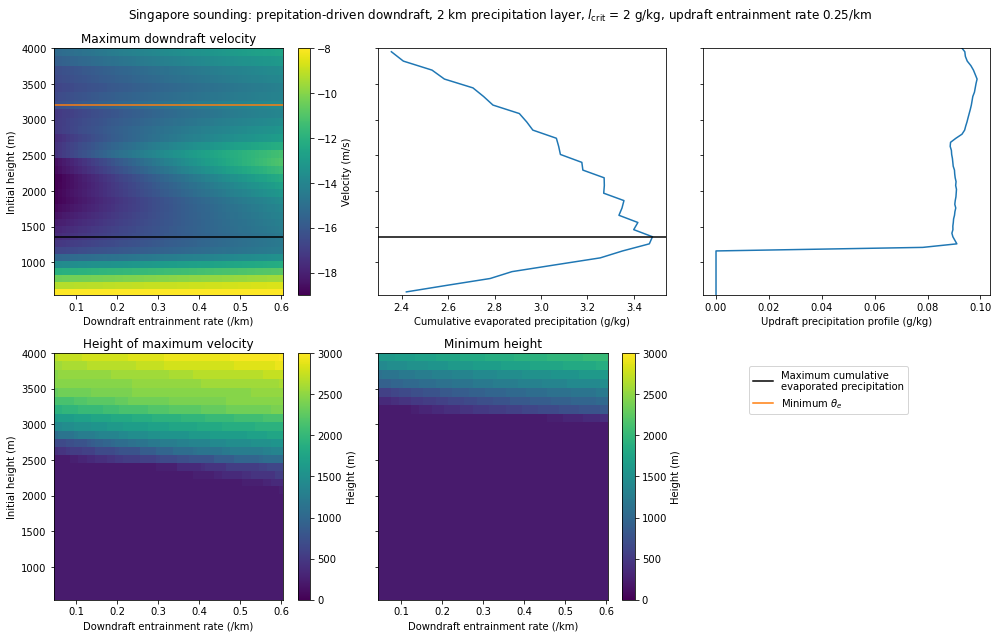

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(14,9))

mesh = axes[0,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity, shading='nearest')
mesh.set_clim(-19, -8)
cbar = plt.colorbar(mesh, ax=axes[0,0])
cbar.set_label('Velocity (m/s)')
axes[0,0].axhline(max_evap_height, color='k',
                  label='Maximum cumulative\nevaporated precipitation')
axes[0,0].axhline(z_min_theta_e, color='tab:orange',
                  label='Minimum $\\theta_e$')
axes[0,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Maximum downdraft velocity')
axes[0,0].set_ylim(540, 4000)

mesh = axes[0,1].plot(total_precip*1e3, z_init_down)
axes[0,1].axhline(max_evap_height, color='k', label='Max evap.')
axes[0,1].set(xlabel='Cumulative evaporated precipitation (g/kg)', ylabel='')
axes[0,1].set_yticklabels([])
axes[0,1].set_ylim(540, 4000)

mesh = axes[0,2].plot(
    updraft.precipitation*updraft.m_remaining*1e3, height)
axes[0,2].set(xlabel='Updraft precipitation profile (g/kg)', ylabel='')
axes[0,2].set_yticklabels([])
axes[0,2].set_ylim(540, 4000)

mesh = axes[1,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,0])
cbar.set_label('Height (m)')
axes[1,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Height of maximum velocity')
axes[1,0].set_ylim(540, 4000)

mesh = axes[1,1].pcolormesh(
    epsilon_down, z_init_down, min_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,1])
cbar.set_label('Height (m)')
axes[1,1].set(xlabel='Downdraft entrainment rate (/km)', ylabel='',
              title='Minimum height')
axes[1,1].set_yticklabels([])
axes[1,1].set_ylim(540, 4000)

axes[1,2].remove()
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.75, 0.35))

fig.suptitle('Singapore sounding: '
             'prepitation-driven downdraft, 2 km precipitation layer, '
             '$l_\mathrm{{crit}}$ = 2 g/kg, updraft entrainment rate 0.25/km')
fig.tight_layout()

### $\epsilon_\mathrm{up} = 0.1 \text{ km}^{-1}$

In [28]:
# updraft parameters
i_init_up = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init_up], temperature[i_init_up])
     - specific_humidity[i_init_up]
)
l_initial = 0*units.dimensionless
l_crit = 2e-3*units.dimensionless
epsilon_up = 0.1/units.km

# downdraft parameters
i_init_down_min = np.min(np.argwhere(height <= 4000*units.meter))
i_init_down_max = np.max(np.argwhere(height >= 500*units.meter))
i_init_down = range(i_init_down_min, i_init_down_max+1, 2)
z_init_down = height[i_init_down_min:i_init_down_max+1:2]
i_precip_top = np.argmin(np.abs(
    np.atleast_2d(height) - np.atleast_2d(z_init_down + 2000*units.meter).T
), axis=1)

# shared parameters
w_initial = 0*units.meter/units.second
epsilon_down = np.arange(0.05, 0.601, 0.01)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [29]:
%%time
downdrafts = np.zeros((z_init_down.size, epsilon_down.size), dtype='object')
total_precip = np.zeros(z_init_down.size)*units('')
n_calc = epsilon_down.size*z_init_down.size
n_done = 0

updraft = generator.updraft(
    i_init_up, t_pert, q_pert, l_initial, w_initial,
    epsilon_up, dnu_db, drag, l_crit, basic=True)

for i in range(z_init_down.size):
    total_precip[i] = np.nansum((
        updraft.precipitation*updraft.m_remaining
    )[i_precip_top[i] : i_init_down[i] + 1])
    for j in range(epsilon_down.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_calc}    ')
        downdrafts[i,j] = generator.precipitation_downdraft(
            i_init_down[i], total_precip[i], w_initial,
            epsilon_down[j], dnu_db, drag, basic=True)

sys.stdout.write('\n')

Calculation 1792 of 1792    
CPU times: user 8min 16s, sys: 4.93 s, total: 8min 21s
Wall time: 8min 33s


1

In [30]:
with shelve.open(
        'generalising_coupling_data/'
        'singapore_detail_fixed_updraft_epsilon_1') as db:
    db['downdrafts'] = downdrafts
    db['updraft'] = updraft
    db['total_precip'] = total_precip
    db['epsilon_up'] = epsilon_up

In [36]:
max_velocity = np.zeros((z_init_down.size, epsilon_down.size))*units('m/s')
max_velocity_height = np.zeros(
    (z_init_down.size, epsilon_down.size))*units.meter
min_height = np.zeros((z_init_down.size, epsilon_down.size))*units.meter

for i in range(z_init_down.size):
    for j in range(epsilon_down.size):
        max_velocity_i = np.nanargmin(downdrafts[i,j].velocity)
        max_velocity[i,j] = downdrafts[i,j].velocity[max_velocity_i]
        max_velocity_height[i,j] = height[max_velocity_i]
        min_height_i = np.max(np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
        min_height[i,j] = height[min_height_i]
                                      
max_evap_height = z_init_down[np.argmax(total_precip, axis=0)]
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)
z_min_theta_e = height[np.argmin(theta_e)]

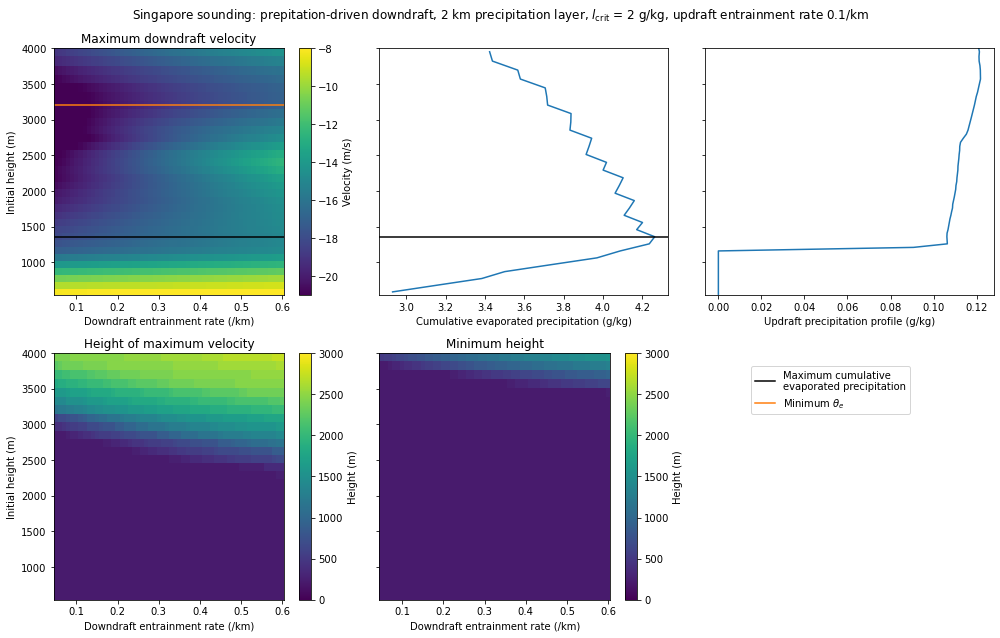

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(14,9))

mesh = axes[0,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity, shading='nearest')
mesh.set_clim(-21, -8)
cbar = plt.colorbar(mesh, ax=axes[0,0])
cbar.set_label('Velocity (m/s)')
axes[0,0].axhline(max_evap_height, color='k',
                  label='Maximum cumulative\nevaporated precipitation')
axes[0,0].axhline(z_min_theta_e, color='tab:orange',
                  label='Minimum $\\theta_e$')
axes[0,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Maximum downdraft velocity')
axes[0,0].set_ylim(540, 4000)

mesh = axes[0,1].plot(total_precip*1e3, z_init_down)
axes[0,1].axhline(max_evap_height, color='k', label='Max evap.')
axes[0,1].set(xlabel='Cumulative evaporated precipitation (g/kg)', ylabel='')
axes[0,1].set_yticklabels([])
axes[0,1].set_ylim(540, 4000)

mesh = axes[0,2].plot(
    updraft.precipitation*updraft.m_remaining*1e3, height)
axes[0,2].set(xlabel='Updraft precipitation profile (g/kg)', ylabel='')
axes[0,2].set_yticklabels([])
axes[0,2].set_ylim(540, 4000)

mesh = axes[1,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,0])
cbar.set_label('Height (m)')
axes[1,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Height of maximum velocity')
axes[1,0].set_ylim(540, 4000)

mesh = axes[1,1].pcolormesh(
    epsilon_down, z_init_down, min_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,1])
cbar.set_label('Height (m)')
axes[1,1].set(xlabel='Downdraft entrainment rate (/km)', ylabel='',
              title='Minimum height')
axes[1,1].set_yticklabels([])
axes[1,1].set_ylim(540, 4000)

axes[1,2].remove()
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.75, 0.35))

fig.suptitle('Singapore sounding: '
             'prepitation-driven downdraft, 2 km precipitation layer, '
             '$l_\mathrm{{crit}}$ = 2 g/kg, updraft entrainment rate 0.1/km')
fig.tight_layout()

### $\epsilon_\mathrm{up} = 0.5 \text{ km}^{-1}$

In [41]:
# updraft parameters
i_init_up = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init_up], temperature[i_init_up])
     - specific_humidity[i_init_up]
)
l_initial = 0*units.dimensionless
l_crit = 2e-3*units.dimensionless
epsilon_up = 0.5/units.km

# downdraft parameters
i_init_down_min = np.min(np.argwhere(height <= 4000*units.meter))
i_init_down_max = np.max(np.argwhere(height >= 500*units.meter))
i_init_down = range(i_init_down_min, i_init_down_max+1, 2)
z_init_down = height[i_init_down_min:i_init_down_max+1:2]
i_precip_top = np.argmin(np.abs(
    np.atleast_2d(height) - np.atleast_2d(z_init_down + 2000*units.meter).T
), axis=1)

# shared parameters
w_initial = 0*units.meter/units.second
epsilon_down = np.arange(0.05, 0.601, 0.01)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [42]:
%%time
downdrafts = np.zeros((z_init_down.size, epsilon_down.size), dtype='object')
total_precip = np.zeros(z_init_down.size)*units('')
n_calc = epsilon_down.size*z_init_down.size
n_done = 0

updraft = generator.updraft(
    i_init_up, t_pert, q_pert, l_initial, w_initial,
    epsilon_up, dnu_db, drag, l_crit, basic=True)

for i in range(z_init_down.size):
    total_precip[i] = np.nansum((
        updraft.precipitation*updraft.m_remaining
    )[i_precip_top[i] : i_init_down[i] + 1])
    for j in range(epsilon_down.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_calc}    ')
        downdrafts[i,j] = generator.precipitation_downdraft(
            i_init_down[i], total_precip[i], w_initial,
            epsilon_down[j], dnu_db, drag, basic=True)

sys.stdout.write('\n')

Calculation 1792 of 1792    
CPU times: user 7min 16s, sys: 5.34 s, total: 7min 21s
Wall time: 7min 40s


1

In [43]:
with shelve.open(
        'generalising_coupling_data/'
        'singapore_detail_fixed_updraft_epsilon_2') as db:
    db['downdrafts'] = downdrafts
    db['updraft'] = updraft
    db['total_precip'] = total_precip
    db['epsilon_up'] = epsilon_up

In [44]:
max_velocity = np.zeros((z_init_down.size, epsilon_down.size))*units('m/s')
max_velocity_height = np.zeros(
    (z_init_down.size, epsilon_down.size))*units.meter
min_height = np.zeros((z_init_down.size, epsilon_down.size))*units.meter

for i in range(z_init_down.size):
    for j in range(epsilon_down.size):
        max_velocity_i = np.nanargmin(downdrafts[i,j].velocity)
        max_velocity[i,j] = downdrafts[i,j].velocity[max_velocity_i]
        max_velocity_height[i,j] = height[max_velocity_i]
        min_height_i = np.max(np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
        min_height[i,j] = height[min_height_i]
                                      
max_evap_height = z_init_down[np.argmax(total_precip, axis=0)]
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)
z_min_theta_e = height[np.argmin(theta_e)]

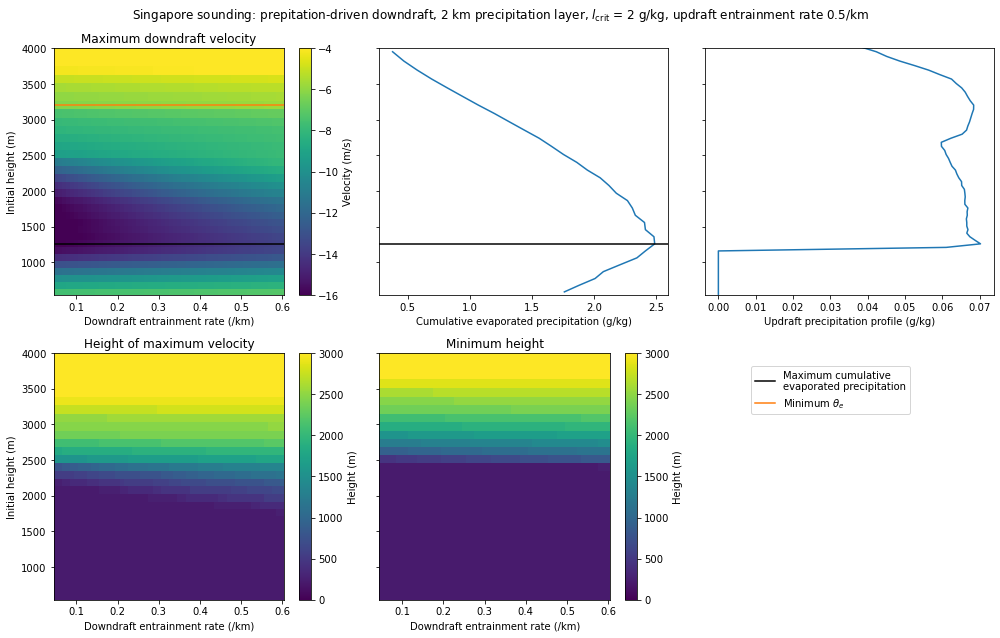

In [49]:
fig, axes = plt.subplots(2, 3, figsize=(14,9))

mesh = axes[0,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity, shading='nearest')
mesh.set_clim(-16, -4)
cbar = plt.colorbar(mesh, ax=axes[0,0])
cbar.set_label('Velocity (m/s)')
axes[0,0].axhline(max_evap_height, color='k',
                  label='Maximum cumulative\nevaporated precipitation')
axes[0,0].axhline(z_min_theta_e, color='tab:orange',
                  label='Minimum $\\theta_e$')
axes[0,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Maximum downdraft velocity')
axes[0,0].set_ylim(540, 4000)

mesh = axes[0,1].plot(total_precip*1e3, z_init_down)
axes[0,1].axhline(max_evap_height, color='k', label='Max evap.')
axes[0,1].set(xlabel='Cumulative evaporated precipitation (g/kg)', ylabel='')
axes[0,1].set_yticklabels([])
axes[0,1].set_ylim(540, 4000)

mesh = axes[0,2].plot(
    updraft.precipitation*updraft.m_remaining*1e3, height)
axes[0,2].set(xlabel='Updraft precipitation profile (g/kg)', ylabel='')
axes[0,2].set_yticklabels([])
axes[0,2].set_ylim(540, 4000)

mesh = axes[1,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,0])
cbar.set_label('Height (m)')
axes[1,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Height of maximum velocity')
axes[1,0].set_ylim(540, 4000)

mesh = axes[1,1].pcolormesh(
    epsilon_down, z_init_down, min_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,1])
cbar.set_label('Height (m)')
axes[1,1].set(xlabel='Downdraft entrainment rate (/km)', ylabel='',
              title='Minimum height')
axes[1,1].set_yticklabels([])
axes[1,1].set_ylim(540, 4000)

axes[1,2].remove()
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.75, 0.35))

fig.suptitle('Singapore sounding: '
             'prepitation-driven downdraft, 2 km precipitation layer, '
             '$l_\mathrm{{crit}}$ = 2 g/kg, updraft entrainment rate 0.5/km')
fig.tight_layout()

### Thicker precipitation layer (3 km)

In [50]:
# updraft parameters
i_init_up = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init_up], temperature[i_init_up])
     - specific_humidity[i_init_up]
)
l_initial = 0*units.dimensionless
l_crit = 2e-3*units.dimensionless
epsilon_up = 0.25/units.km

# downdraft parameters
i_init_down_min = np.min(np.argwhere(height <= 4000*units.meter))
i_init_down_max = np.max(np.argwhere(height >= 500*units.meter))
i_init_down = range(i_init_down_min, i_init_down_max+1, 2)
z_init_down = height[i_init_down_min:i_init_down_max+1:2]
i_precip_top = np.argmin(np.abs(
    np.atleast_2d(height) - np.atleast_2d(z_init_down + 3000*units.meter).T
), axis=1)

# shared parameters
w_initial = 0*units.meter/units.second
epsilon_down = np.arange(0.05, 0.601, 0.01)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [51]:
%%time
downdrafts = np.zeros((z_init_down.size, epsilon_down.size), dtype='object')
total_precip = np.zeros(z_init_down.size)*units('')
n_calc = epsilon_down.size*z_init_down.size
n_done = 0

updraft = generator.updraft(
    i_init_up, t_pert, q_pert, l_initial, w_initial,
    epsilon_up, dnu_db, drag, l_crit, basic=True)

for i in range(z_init_down.size):
    total_precip[i] = np.nansum((
        updraft.precipitation*updraft.m_remaining
    )[i_precip_top[i] : i_init_down[i] + 1])
    for j in range(epsilon_down.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_calc}    ')
        downdrafts[i,j] = generator.precipitation_downdraft(
            i_init_down[i], total_precip[i], w_initial,
            epsilon_down[j], dnu_db, drag, basic=True)

sys.stdout.write('\n')

Calculation 1792 of 1792    
CPU times: user 8min 37s, sys: 6.28 s, total: 8min 43s
Wall time: 9min 16s


1

In [52]:
with shelve.open(
        'generalising_coupling_data/'
        'singapore_detail_fixed_updraft_epsilon_3') as db:
    db['downdrafts'] = downdrafts
    db['updraft'] = updraft
    db['total_precip'] = total_precip
    db['epsilon_up'] = epsilon_up

In [53]:
max_velocity = np.zeros((z_init_down.size, epsilon_down.size))*units('m/s')
max_velocity_height = np.zeros(
    (z_init_down.size, epsilon_down.size))*units.meter
min_height = np.zeros((z_init_down.size, epsilon_down.size))*units.meter

for i in range(z_init_down.size):
    for j in range(epsilon_down.size):
        max_velocity_i = np.nanargmin(downdrafts[i,j].velocity)
        max_velocity[i,j] = downdrafts[i,j].velocity[max_velocity_i]
        max_velocity_height[i,j] = height[max_velocity_i]
        min_height_i = np.max(np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
        min_height[i,j] = height[min_height_i]
                                      
max_evap_height = z_init_down[np.argmax(total_precip, axis=0)]
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)
z_min_theta_e = height[np.argmin(theta_e)]

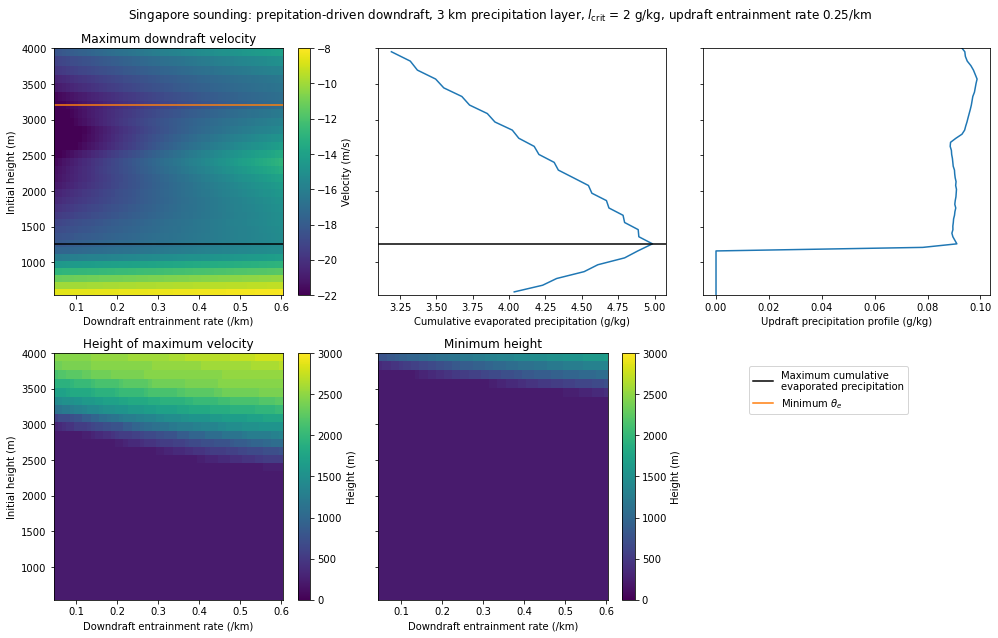

In [56]:
fig, axes = plt.subplots(2, 3, figsize=(14,9))

mesh = axes[0,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity, shading='nearest')
mesh.set_clim(-22, -8)
cbar = plt.colorbar(mesh, ax=axes[0,0])
cbar.set_label('Velocity (m/s)')
axes[0,0].axhline(max_evap_height, color='k',
                  label='Maximum cumulative\nevaporated precipitation')
axes[0,0].axhline(z_min_theta_e, color='tab:orange',
                  label='Minimum $\\theta_e$')
axes[0,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Maximum downdraft velocity')
axes[0,0].set_ylim(540, 4000)

mesh = axes[0,1].plot(total_precip*1e3, z_init_down)
axes[0,1].axhline(max_evap_height, color='k', label='Max evap.')
axes[0,1].set(xlabel='Cumulative evaporated precipitation (g/kg)', ylabel='')
axes[0,1].set_yticklabels([])
axes[0,1].set_ylim(540, 4000)

mesh = axes[0,2].plot(
    updraft.precipitation*updraft.m_remaining*1e3, height)
axes[0,2].set(xlabel='Updraft precipitation profile (g/kg)', ylabel='')
axes[0,2].set_yticklabels([])
axes[0,2].set_ylim(540, 4000)

mesh = axes[1,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,0])
cbar.set_label('Height (m)')
axes[1,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Height of maximum velocity')
axes[1,0].set_ylim(540, 4000)

mesh = axes[1,1].pcolormesh(
    epsilon_down, z_init_down, min_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,1])
cbar.set_label('Height (m)')
axes[1,1].set(xlabel='Downdraft entrainment rate (/km)', ylabel='',
              title='Minimum height')
axes[1,1].set_yticklabels([])
axes[1,1].set_ylim(540, 4000)

axes[1,2].remove()
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.75, 0.35))

fig.suptitle('Singapore sounding: '
             'prepitation-driven downdraft, 3 km precipitation layer, '
             '$l_\mathrm{{crit}}$ = 2 g/kg, updraft entrainment rate 0.25/km')
fig.tight_layout()

### Thinner precipitation layer (1 km)

In [57]:
# updraft parameters
i_init_up = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init_up], temperature[i_init_up])
     - specific_humidity[i_init_up]
)
l_initial = 0*units.dimensionless
l_crit = 2e-3*units.dimensionless
epsilon_up = 0.25/units.km

# downdraft parameters
i_init_down_min = np.min(np.argwhere(height <= 4000*units.meter))
i_init_down_max = np.max(np.argwhere(height >= 500*units.meter))
i_init_down = range(i_init_down_min, i_init_down_max+1, 2)
z_init_down = height[i_init_down_min:i_init_down_max+1:2]
i_precip_top = np.argmin(np.abs(
    np.atleast_2d(height) - np.atleast_2d(z_init_down + 1000*units.meter).T
), axis=1)

# shared parameters
w_initial = 0*units.meter/units.second
epsilon_down = np.arange(0.05, 0.601, 0.01)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [58]:
%%time
downdrafts = np.zeros((z_init_down.size, epsilon_down.size), dtype='object')
total_precip = np.zeros(z_init_down.size)*units('')
n_calc = epsilon_down.size*z_init_down.size
n_done = 0

updraft = generator.updraft(
    i_init_up, t_pert, q_pert, l_initial, w_initial,
    epsilon_up, dnu_db, drag, l_crit, basic=True)

for i in range(z_init_down.size):
    total_precip[i] = np.nansum((
        updraft.precipitation*updraft.m_remaining
    )[i_precip_top[i] : i_init_down[i] + 1])
    for j in range(epsilon_down.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_calc}    ')
        downdrafts[i,j] = generator.precipitation_downdraft(
            i_init_down[i], total_precip[i], w_initial,
            epsilon_down[j], dnu_db, drag, basic=True)

sys.stdout.write('\n')

Calculation 1792 of 1792    
CPU times: user 7min 35s, sys: 5.46 s, total: 7min 41s
Wall time: 8min 1s


1

In [59]:
with shelve.open(
        'generalising_coupling_data/'
        'singapore_detail_fixed_updraft_epsilon_4') as db:
    db['downdrafts'] = downdrafts
    db['updraft'] = updraft
    db['total_precip'] = total_precip
    db['epsilon_up'] = epsilon_up

In [60]:
max_velocity = np.zeros((z_init_down.size, epsilon_down.size))*units('m/s')
max_velocity_height = np.zeros(
    (z_init_down.size, epsilon_down.size))*units.meter
min_height = np.zeros((z_init_down.size, epsilon_down.size))*units.meter

for i in range(z_init_down.size):
    for j in range(epsilon_down.size):
        max_velocity_i = np.nanargmin(downdrafts[i,j].velocity)
        max_velocity[i,j] = downdrafts[i,j].velocity[max_velocity_i]
        max_velocity_height[i,j] = height[max_velocity_i]
        min_height_i = np.max(np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
        min_height[i,j] = height[min_height_i]
                                      
max_evap_height = z_init_down[np.argmax(total_precip, axis=0)]
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)
z_min_theta_e = height[np.argmin(theta_e)]

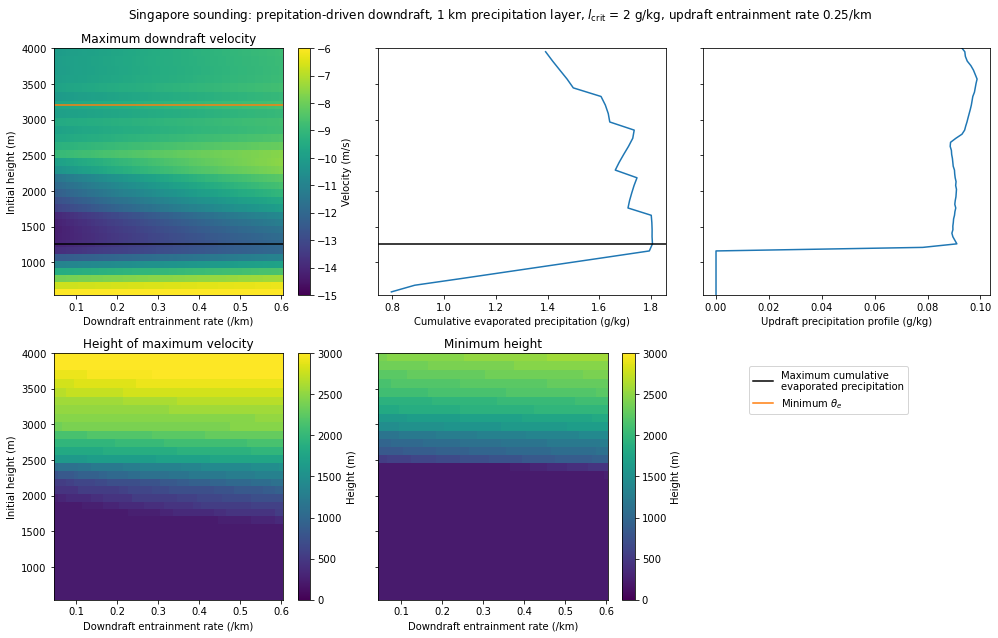

In [64]:
fig, axes = plt.subplots(2, 3, figsize=(14,9))

mesh = axes[0,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity, shading='nearest')
mesh.set_clim(-15, -6)
cbar = plt.colorbar(mesh, ax=axes[0,0])
cbar.set_label('Velocity (m/s)')
axes[0,0].axhline(max_evap_height, color='k',
                  label='Maximum cumulative\nevaporated precipitation')
axes[0,0].axhline(z_min_theta_e, color='tab:orange',
                  label='Minimum $\\theta_e$')
axes[0,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Maximum downdraft velocity')
axes[0,0].set_ylim(540, 4000)

mesh = axes[0,1].plot(total_precip*1e3, z_init_down)
axes[0,1].axhline(max_evap_height, color='k', label='Max evap.')
axes[0,1].set(xlabel='Cumulative evaporated precipitation (g/kg)', ylabel='')
axes[0,1].set_yticklabels([])
axes[0,1].set_ylim(540, 4000)

mesh = axes[0,2].plot(
    updraft.precipitation*updraft.m_remaining*1e3, height)
axes[0,2].set(xlabel='Updraft precipitation profile (g/kg)', ylabel='')
axes[0,2].set_yticklabels([])
axes[0,2].set_ylim(540, 4000)

mesh = axes[1,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,0])
cbar.set_label('Height (m)')
axes[1,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Height of maximum velocity')
axes[1,0].set_ylim(540, 4000)

mesh = axes[1,1].pcolormesh(
    epsilon_down, z_init_down, min_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,1])
cbar.set_label('Height (m)')
axes[1,1].set(xlabel='Downdraft entrainment rate (/km)', ylabel='',
              title='Minimum height')
axes[1,1].set_yticklabels([])
axes[1,1].set_ylim(540, 4000)

axes[1,2].remove()
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.75, 0.35))

fig.suptitle('Singapore sounding: '
             'prepitation-driven downdraft, 1 km precipitation layer, '
             '$l_\mathrm{{crit}}$ = 2 g/kg, updraft entrainment rate 0.25/km')
fig.tight_layout()

### Lower precipitation threshold (1 g/kg)

In [65]:
# updraft parameters
i_init_up = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init_up], temperature[i_init_up])
     - specific_humidity[i_init_up]
)
l_initial = 0*units.dimensionless
l_crit = 1e-3*units.dimensionless
epsilon_up = 0.25/units.km

# downdraft parameters
i_init_down_min = np.min(np.argwhere(height <= 4000*units.meter))
i_init_down_max = np.max(np.argwhere(height >= 500*units.meter))
i_init_down = range(i_init_down_min, i_init_down_max+1, 2)
z_init_down = height[i_init_down_min:i_init_down_max+1:2]
i_precip_top = np.argmin(np.abs(
    np.atleast_2d(height) - np.atleast_2d(z_init_down + 2000*units.meter).T
), axis=1)

# shared parameters
w_initial = 0*units.meter/units.second
epsilon_down = np.arange(0.05, 0.601, 0.01)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [66]:
%%time
downdrafts = np.zeros((z_init_down.size, epsilon_down.size), dtype='object')
total_precip = np.zeros(z_init_down.size)*units('')
n_calc = epsilon_down.size*z_init_down.size
n_done = 0

updraft = generator.updraft(
    i_init_up, t_pert, q_pert, l_initial, w_initial,
    epsilon_up, dnu_db, drag, l_crit, basic=True)

for i in range(z_init_down.size):
    total_precip[i] = np.nansum((
        updraft.precipitation*updraft.m_remaining
    )[i_precip_top[i] : i_init_down[i] + 1])
    for j in range(epsilon_down.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_calc}    ')
        downdrafts[i,j] = generator.precipitation_downdraft(
            i_init_down[i], total_precip[i], w_initial,
            epsilon_down[j], dnu_db, drag, basic=True)

sys.stdout.write('\n')

Calculation 1792 of 1792    
CPU times: user 7min 41s, sys: 3.39 s, total: 7min 44s
Wall time: 7min 47s


1

In [67]:
with shelve.open(
        'generalising_coupling_data/'
        'singapore_detail_fixed_updraft_epsilon_5') as db:
    db['downdrafts'] = downdrafts
    db['updraft'] = updraft
    db['total_precip'] = total_precip
    db['epsilon_up'] = epsilon_up

In [68]:
max_velocity = np.zeros((z_init_down.size, epsilon_down.size))*units('m/s')
max_velocity_height = np.zeros(
    (z_init_down.size, epsilon_down.size))*units.meter
min_height = np.zeros((z_init_down.size, epsilon_down.size))*units.meter

for i in range(z_init_down.size):
    for j in range(epsilon_down.size):
        max_velocity_i = np.nanargmin(downdrafts[i,j].velocity)
        max_velocity[i,j] = downdrafts[i,j].velocity[max_velocity_i]
        max_velocity_height[i,j] = height[max_velocity_i]
        min_height_i = np.max(np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
        min_height[i,j] = height[min_height_i]
                                      
max_evap_height = z_init_down[np.argmax(total_precip, axis=0)]
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)
z_min_theta_e = height[np.argmin(theta_e)]

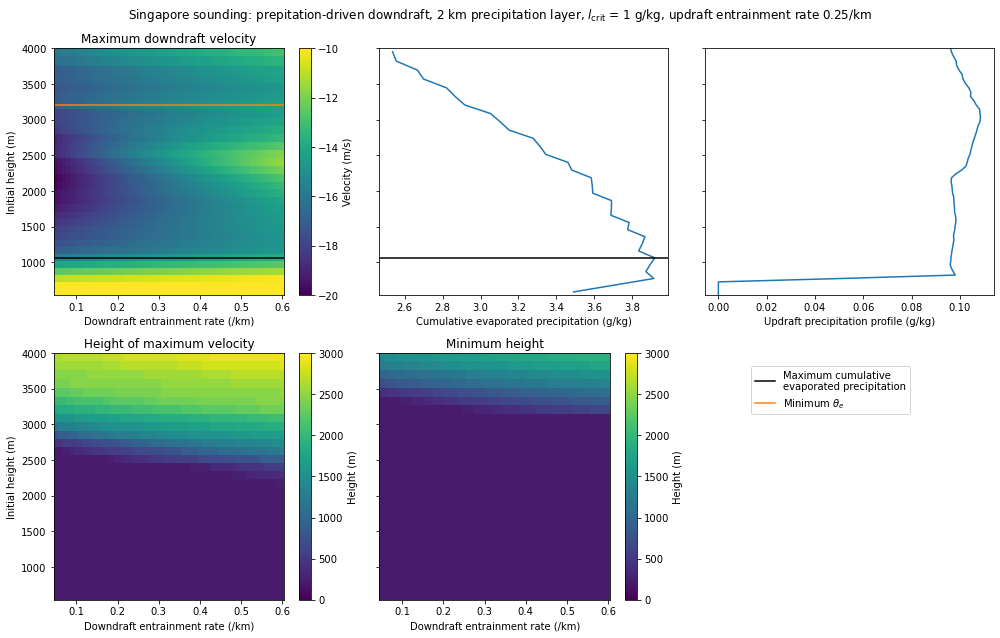

In [71]:
fig, axes = plt.subplots(2, 3, figsize=(14,9))

mesh = axes[0,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity, shading='nearest')
mesh.set_clim(-20, -10)
cbar = plt.colorbar(mesh, ax=axes[0,0])
cbar.set_label('Velocity (m/s)')
axes[0,0].axhline(max_evap_height, color='k',
                  label='Maximum cumulative\nevaporated precipitation')
axes[0,0].axhline(z_min_theta_e, color='tab:orange',
                  label='Minimum $\\theta_e$')
axes[0,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Maximum downdraft velocity')
axes[0,0].set_ylim(540, 4000)

mesh = axes[0,1].plot(total_precip*1e3, z_init_down)
axes[0,1].axhline(max_evap_height, color='k', label='Max evap.')
axes[0,1].set(xlabel='Cumulative evaporated precipitation (g/kg)', ylabel='')
axes[0,1].set_yticklabels([])
axes[0,1].set_ylim(540, 4000)

mesh = axes[0,2].plot(
    updraft.precipitation*updraft.m_remaining*1e3, height)
axes[0,2].set(xlabel='Updraft precipitation profile (g/kg)', ylabel='')
axes[0,2].set_yticklabels([])
axes[0,2].set_ylim(540, 4000)

mesh = axes[1,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,0])
cbar.set_label('Height (m)')
axes[1,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Height of maximum velocity')
axes[1,0].set_ylim(540, 4000)

mesh = axes[1,1].pcolormesh(
    epsilon_down, z_init_down, min_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,1])
cbar.set_label('Height (m)')
axes[1,1].set(xlabel='Downdraft entrainment rate (/km)', ylabel='',
              title='Minimum height')
axes[1,1].set_yticklabels([])
axes[1,1].set_ylim(540, 4000)

axes[1,2].remove()
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.75, 0.35))

fig.suptitle('Singapore sounding: '
             'prepitation-driven downdraft, 2 km precipitation layer, '
             '$l_\mathrm{{crit}}$ = 1 g/kg, updraft entrainment rate 0.25/km')
fig.tight_layout()

### Higher precipitation threshold (3 g/kg)

In [72]:
# updraft parameters
i_init_up = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init_up], temperature[i_init_up])
     - specific_humidity[i_init_up]
)
l_initial = 0*units.dimensionless
l_crit = 3e-3*units.dimensionless
epsilon_up = 0.25/units.km

# downdraft parameters
i_init_down_min = np.min(np.argwhere(height <= 4000*units.meter))
i_init_down_max = np.max(np.argwhere(height >= 500*units.meter))
i_init_down = range(i_init_down_min, i_init_down_max+1, 2)
z_init_down = height[i_init_down_min:i_init_down_max+1:2]
i_precip_top = np.argmin(np.abs(
    np.atleast_2d(height) - np.atleast_2d(z_init_down + 2000*units.meter).T
), axis=1)

# shared parameters
w_initial = 0*units.meter/units.second
epsilon_down = np.arange(0.05, 0.601, 0.01)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [73]:
%%time
downdrafts = np.zeros((z_init_down.size, epsilon_down.size), dtype='object')
total_precip = np.zeros(z_init_down.size)*units('')
n_calc = epsilon_down.size*z_init_down.size
n_done = 0

updraft = generator.updraft(
    i_init_up, t_pert, q_pert, l_initial, w_initial,
    epsilon_up, dnu_db, drag, l_crit, basic=True)

for i in range(z_init_down.size):
    total_precip[i] = np.nansum((
        updraft.precipitation*updraft.m_remaining
    )[i_precip_top[i] : i_init_down[i] + 1])
    for j in range(epsilon_down.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_calc}    ')
        downdrafts[i,j] = generator.precipitation_downdraft(
            i_init_down[i], total_precip[i], w_initial,
            epsilon_down[j], dnu_db, drag, basic=True)

sys.stdout.write('\n')

Calculation 1792 of 1792    
CPU times: user 8min, sys: 4.4 s, total: 8min 5s
Wall time: 8min 14s


1

In [74]:
with shelve.open(
        'generalising_coupling_data/'
        'singapore_detail_fixed_updraft_epsilon_6') as db:
    db['downdrafts'] = downdrafts
    db['updraft'] = updraft
    db['total_precip'] = total_precip
    db['epsilon_up'] = epsilon_up

In [75]:
max_velocity = np.zeros((z_init_down.size, epsilon_down.size))*units('m/s')
max_velocity_height = np.zeros(
    (z_init_down.size, epsilon_down.size))*units.meter
min_height = np.zeros((z_init_down.size, epsilon_down.size))*units.meter

for i in range(z_init_down.size):
    for j in range(epsilon_down.size):
        max_velocity_i = np.nanargmin(downdrafts[i,j].velocity)
        max_velocity[i,j] = downdrafts[i,j].velocity[max_velocity_i]
        max_velocity_height[i,j] = height[max_velocity_i]
        min_height_i = np.max(np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
        min_height[i,j] = height[min_height_i]
                                      
max_evap_height = z_init_down[np.argmax(total_precip, axis=0)]
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)
z_min_theta_e = height[np.argmin(theta_e)]

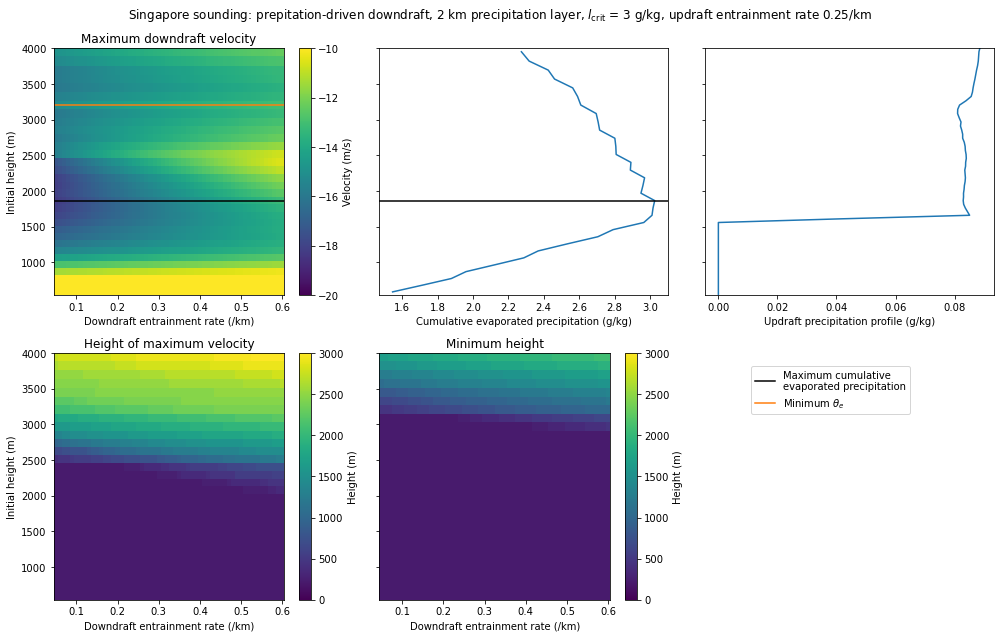

In [76]:
fig, axes = plt.subplots(2, 3, figsize=(14,9))

mesh = axes[0,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity, shading='nearest')
mesh.set_clim(-20, -10)
cbar = plt.colorbar(mesh, ax=axes[0,0])
cbar.set_label('Velocity (m/s)')
axes[0,0].axhline(max_evap_height, color='k',
                  label='Maximum cumulative\nevaporated precipitation')
axes[0,0].axhline(z_min_theta_e, color='tab:orange',
                  label='Minimum $\\theta_e$')
axes[0,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Maximum downdraft velocity')
axes[0,0].set_ylim(540, 4000)

mesh = axes[0,1].plot(total_precip*1e3, z_init_down)
axes[0,1].axhline(max_evap_height, color='k', label='Max evap.')
axes[0,1].set(xlabel='Cumulative evaporated precipitation (g/kg)', ylabel='')
axes[0,1].set_yticklabels([])
axes[0,1].set_ylim(540, 4000)

mesh = axes[0,2].plot(
    updraft.precipitation*updraft.m_remaining*1e3, height)
axes[0,2].set(xlabel='Updraft precipitation profile (g/kg)', ylabel='')
axes[0,2].set_yticklabels([])
axes[0,2].set_ylim(540, 4000)

mesh = axes[1,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,0])
cbar.set_label('Height (m)')
axes[1,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Height of maximum velocity')
axes[1,0].set_ylim(540, 4000)

mesh = axes[1,1].pcolormesh(
    epsilon_down, z_init_down, min_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,1])
cbar.set_label('Height (m)')
axes[1,1].set(xlabel='Downdraft entrainment rate (/km)', ylabel='',
              title='Minimum height')
axes[1,1].set_yticklabels([])
axes[1,1].set_ylim(540, 4000)

axes[1,2].remove()
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.75, 0.35))

fig.suptitle('Singapore sounding: '
             'prepitation-driven downdraft, 2 km precipitation layer, '
             '$l_\mathrm{{crit}}$ = 3 g/kg, updraft entrainment rate 0.25/km')
fig.tight_layout()

## Williamtown sounding

In [121]:
file = ('test_soundings/94776 YSWM Williamtown Amo Raaf Observations '
        'at 00Z 21 Dec 2021.txt')
sounding = pd.read_fwf(file, usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure_raw = sounding[:2:-1,0]
height_raw = sounding[:2:-1,1]
height_raw -= np.min(height_raw)
temperature_raw = sounding[:2:-1,2]
dewpoint_raw = sounding[:2:-1,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], 5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)
generator = CoupledThermalGenerator(
    pressure, height, temperature, specific_humidity)

### $\epsilon_\mathrm{up} = 0.25 \text{ km}^{-1}$

In [122]:
# updraft parameters
i_init_up = pressure.size - 1
t_pert = 1.5*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init_up], temperature[i_init_up])
     - specific_humidity[i_init_up]
)
l_initial = 0*units.dimensionless
l_crit = 2e-3*units.dimensionless
epsilon_up = 0.25/units.km

# downdraft parameters
i_init_down_min = np.min(np.argwhere(height <= 4000*units.meter))
i_init_down_max = np.max(np.argwhere(height >= 500*units.meter))
i_init_down = range(i_init_down_min, i_init_down_max+1, 2)
z_init_down = height[i_init_down_min:i_init_down_max+1:2]
i_precip_top = np.argmin(np.abs(
    np.atleast_2d(height) - np.atleast_2d(z_init_down + 2000*units.meter).T
), axis=1)

# shared parameters
w_initial = 0*units.meter/units.second
epsilon_down = np.arange(0.05, 0.601, 0.02)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [123]:
%%time
downdrafts = np.zeros((z_init_down.size, epsilon_down.size), dtype='object')
total_precip = np.zeros(z_init_down.size)*units('')
n_calc = epsilon_down.size*z_init_down.size
n_done = 0

updraft = generator.updraft(
    i_init_up, t_pert, q_pert, l_initial, w_initial,
    epsilon_up, dnu_db, drag, l_crit, basic=True)

for i in range(z_init_down.size):
    total_precip[i] = np.nansum((
        updraft.precipitation*updraft.m_remaining
    )[i_precip_top[i] : i_init_down[i] + 1])
    for j in range(epsilon_down.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_calc}    ')
        downdrafts[i,j] = generator.precipitation_downdraft(
            i_init_down[i], total_precip[i], w_initial,
            epsilon_down[j], dnu_db, drag, basic=True)

sys.stdout.write('\n')

Calculation 868 of 868    
CPU times: user 3min 54s, sys: 2.13 s, total: 3min 56s
Wall time: 4min


1

In [124]:
with shelve.open(
        'generalising_coupling_data/'
        'williamtown_detail_fixed_updraft_epsilon_0') as db:
    db['downdrafts'] = downdrafts
    db['updraft'] = updraft
    db['total_precip'] = total_precip
    db['epsilon_up'] = epsilon_up

In [125]:
max_velocity = np.zeros((z_init_down.size, epsilon_down.size))*units('m/s')
max_velocity_height = np.zeros(
    (z_init_down.size, epsilon_down.size))*units.meter
min_height = np.zeros((z_init_down.size, epsilon_down.size))*units.meter

for i in range(z_init_down.size):
    for j in range(epsilon_down.size):
        max_velocity_i = np.nanargmin(downdrafts[i,j].velocity)
        max_velocity[i,j] = downdrafts[i,j].velocity[max_velocity_i]
        max_velocity_height[i,j] = height[max_velocity_i]
        min_height_i = np.max(np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
        min_height[i,j] = height[min_height_i]
                                      
max_evap_height = z_init_down[np.argmax(total_precip, axis=0)]
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)
z_min_theta_e = height[np.argmin(theta_e)]

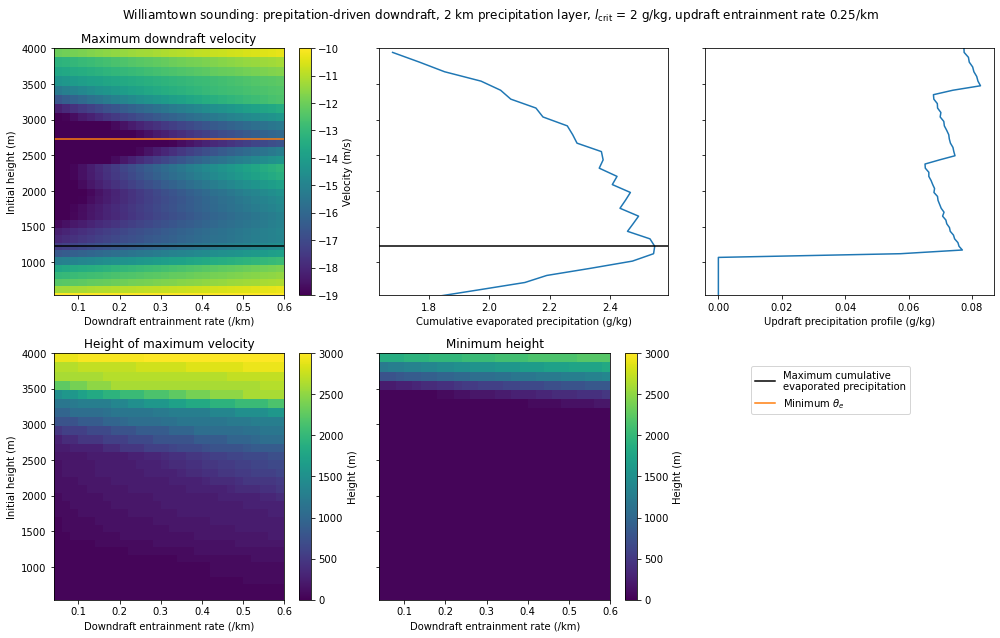

In [127]:
fig, axes = plt.subplots(2, 3, figsize=(14,9))

mesh = axes[0,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity, shading='nearest')
mesh.set_clim(-19, -10)
cbar = plt.colorbar(mesh, ax=axes[0,0])
cbar.set_label('Velocity (m/s)')
axes[0,0].axhline(max_evap_height, color='k',
                  label='Maximum cumulative\nevaporated precipitation')
axes[0,0].axhline(z_min_theta_e, color='tab:orange',
                  label='Minimum $\\theta_e$')
axes[0,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Maximum downdraft velocity')
axes[0,0].set_ylim(540, 4000)

mesh = axes[0,1].plot(total_precip*1e3, z_init_down)
axes[0,1].axhline(max_evap_height, color='k', label='Max evap.')
axes[0,1].set(xlabel='Cumulative evaporated precipitation (g/kg)', ylabel='')
axes[0,1].set_yticklabels([])
axes[0,1].set_ylim(540, 4000)

mesh = axes[0,2].plot(
    updraft.precipitation*updraft.m_remaining*1e3, height)
axes[0,2].set(xlabel='Updraft precipitation profile (g/kg)', ylabel='')
axes[0,2].set_yticklabels([])
axes[0,2].set_ylim(540, 4000)

mesh = axes[1,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,0])
cbar.set_label('Height (m)')
axes[1,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Height of maximum velocity')
axes[1,0].set_ylim(540, 4000)

mesh = axes[1,1].pcolormesh(
    epsilon_down, z_init_down, min_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,1])
cbar.set_label('Height (m)')
axes[1,1].set(xlabel='Downdraft entrainment rate (/km)', ylabel='',
              title='Minimum height')
axes[1,1].set_yticklabels([])
axes[1,1].set_ylim(540, 4000)

axes[1,2].remove()
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.75, 0.35))

fig.suptitle('Williamtown sounding: '
             'prepitation-driven downdraft, 2 km precipitation layer, '
             '$l_\mathrm{{crit}}$ = 2 g/kg, updraft entrainment rate 0.25/km')
fig.tight_layout()

### $\epsilon_\mathrm{up} = 0.1 \text{ km}^{-1}$

In [128]:
# updraft parameters
i_init_up = pressure.size - 1
t_pert = 1.5*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init_up], temperature[i_init_up])
     - specific_humidity[i_init_up]
)
l_initial = 0*units.dimensionless
l_crit = 2e-3*units.dimensionless
epsilon_up = 0.1/units.km

# downdraft parameters
i_init_down_min = np.min(np.argwhere(height <= 4000*units.meter))
i_init_down_max = np.max(np.argwhere(height >= 500*units.meter))
i_init_down = range(i_init_down_min, i_init_down_max+1, 2)
z_init_down = height[i_init_down_min:i_init_down_max+1:2]
i_precip_top = np.argmin(np.abs(
    np.atleast_2d(height) - np.atleast_2d(z_init_down + 2000*units.meter).T
), axis=1)

# shared parameters
w_initial = 0*units.meter/units.second
epsilon_down = np.arange(0.05, 0.601, 0.02)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [129]:
%%time
downdrafts = np.zeros((z_init_down.size, epsilon_down.size), dtype='object')
total_precip = np.zeros(z_init_down.size)*units('')
n_calc = epsilon_down.size*z_init_down.size
n_done = 0

updraft = generator.updraft(
    i_init_up, t_pert, q_pert, l_initial, w_initial,
    epsilon_up, dnu_db, drag, l_crit, basic=True)

for i in range(z_init_down.size):
    total_precip[i] = np.nansum((
        updraft.precipitation*updraft.m_remaining
    )[i_precip_top[i] : i_init_down[i] + 1])
    for j in range(epsilon_down.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_calc}    ')
        downdrafts[i,j] = generator.precipitation_downdraft(
            i_init_down[i], total_precip[i], w_initial,
            epsilon_down[j], dnu_db, drag, basic=True)

sys.stdout.write('\n')

Calculation 868 of 868    
CPU times: user 4min 14s, sys: 2.59 s, total: 4min 16s
Wall time: 4min 35s


1

In [130]:
max_velocity = np.zeros((z_init_down.size, epsilon_down.size))*units('m/s')
max_velocity_height = np.zeros(
    (z_init_down.size, epsilon_down.size))*units.meter
min_height = np.zeros((z_init_down.size, epsilon_down.size))*units.meter

for i in range(z_init_down.size):
    for j in range(epsilon_down.size):
        max_velocity_i = np.nanargmin(downdrafts[i,j].velocity)
        max_velocity[i,j] = downdrafts[i,j].velocity[max_velocity_i]
        max_velocity_height[i,j] = height[max_velocity_i]
        min_height_i = np.max(np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
        min_height[i,j] = height[min_height_i]
                                      
max_evap_height = z_init_down[np.argmax(total_precip, axis=0)]
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)
z_min_theta_e = height[np.argmin(theta_e)]

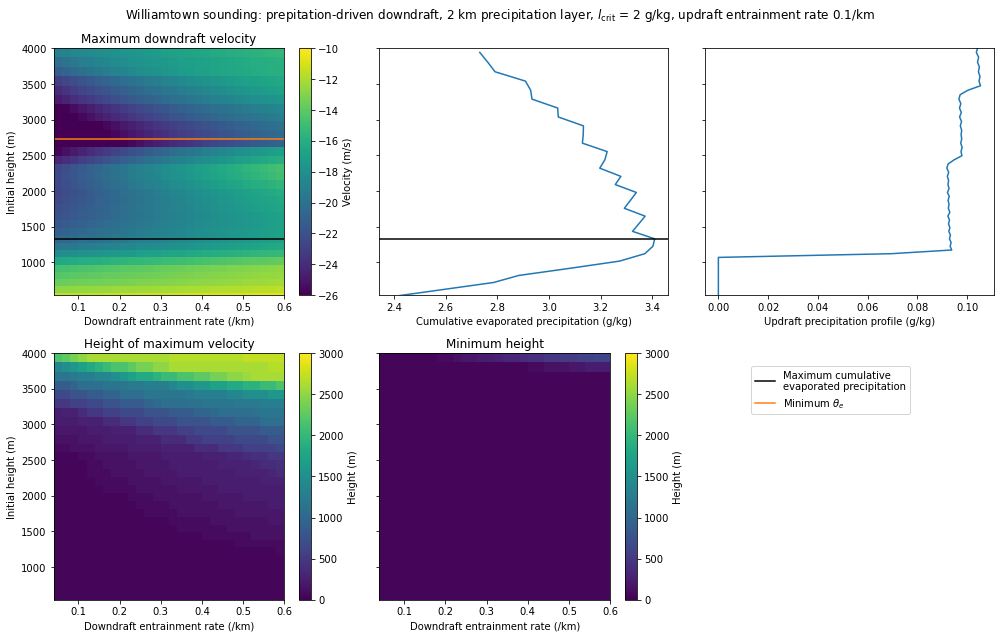

In [135]:
fig, axes = plt.subplots(2, 3, figsize=(14,9))

mesh = axes[0,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity, shading='nearest')
mesh.set_clim(-26, -10)
cbar = plt.colorbar(mesh, ax=axes[0,0])
cbar.set_label('Velocity (m/s)')
axes[0,0].axhline(max_evap_height, color='k',
                  label='Maximum cumulative\nevaporated precipitation')
axes[0,0].axhline(z_min_theta_e, color='tab:orange',
                  label='Minimum $\\theta_e$')
axes[0,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Maximum downdraft velocity')
axes[0,0].set_ylim(540, 4000)

mesh = axes[0,1].plot(total_precip*1e3, z_init_down)
axes[0,1].axhline(max_evap_height, color='k', label='Max evap.')
axes[0,1].set(xlabel='Cumulative evaporated precipitation (g/kg)', ylabel='')
axes[0,1].set_yticklabels([])
axes[0,1].set_ylim(540, 4000)

mesh = axes[0,2].plot(
    updraft.precipitation*updraft.m_remaining*1e3, height)
axes[0,2].set(xlabel='Updraft precipitation profile (g/kg)', ylabel='')
axes[0,2].set_yticklabels([])
axes[0,2].set_ylim(540, 4000)

mesh = axes[1,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,0])
cbar.set_label('Height (m)')
axes[1,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Height of maximum velocity')
axes[1,0].set_ylim(540, 4000)

mesh = axes[1,1].pcolormesh(
    epsilon_down, z_init_down, min_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,1])
cbar.set_label('Height (m)')
axes[1,1].set(xlabel='Downdraft entrainment rate (/km)', ylabel='',
              title='Minimum height')
axes[1,1].set_yticklabels([])
axes[1,1].set_ylim(540, 4000)

axes[1,2].remove()
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.75, 0.35))

fig.suptitle('Williamtown sounding: '
             'prepitation-driven downdraft, 2 km precipitation layer, '
             '$l_\mathrm{{crit}}$ = 2 g/kg, updraft entrainment rate 0.1/km')
fig.tight_layout()

### $\epsilon_\mathrm{up} = 0.5 \text{ km}^{-1}$

In [136]:
# updraft parameters
i_init_up = pressure.size - 1
t_pert = 1.5*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init_up], temperature[i_init_up])
     - specific_humidity[i_init_up]
)
l_initial = 0*units.dimensionless
l_crit = 2e-3*units.dimensionless
epsilon_up = 0.5/units.km

# downdraft parameters
i_init_down_min = np.min(np.argwhere(height <= 4000*units.meter))
i_init_down_max = np.max(np.argwhere(height >= 500*units.meter))
i_init_down = range(i_init_down_min, i_init_down_max+1, 2)
z_init_down = height[i_init_down_min:i_init_down_max+1:2]
i_precip_top = np.argmin(np.abs(
    np.atleast_2d(height) - np.atleast_2d(z_init_down + 2000*units.meter).T
), axis=1)

# shared parameters
w_initial = 0*units.meter/units.second
epsilon_down = np.arange(0.05, 0.601, 0.02)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [137]:
%%time
downdrafts = np.zeros((z_init_down.size, epsilon_down.size), dtype='object')
total_precip = np.zeros(z_init_down.size)*units('')
n_calc = epsilon_down.size*z_init_down.size
n_done = 0

updraft = generator.updraft(
    i_init_up, t_pert, q_pert, l_initial, w_initial,
    epsilon_up, dnu_db, drag, l_crit, basic=True)

for i in range(z_init_down.size):
    total_precip[i] = np.nansum((
        updraft.precipitation*updraft.m_remaining
    )[i_precip_top[i] : i_init_down[i] + 1])
    for j in range(epsilon_down.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_calc}    ')
        downdrafts[i,j] = generator.precipitation_downdraft(
            i_init_down[i], total_precip[i], w_initial,
            epsilon_down[j], dnu_db, drag, basic=True)

sys.stdout.write('\n')

Calculation 868 of 868    
CPU times: user 4min 26s, sys: 5.55 s, total: 4min 31s
Wall time: 5min 56s


1

In [130]:
max_velocity = np.zeros((z_init_down.size, epsilon_down.size))*units('m/s')
max_velocity_height = np.zeros(
    (z_init_down.size, epsilon_down.size))*units.meter
min_height = np.zeros((z_init_down.size, epsilon_down.size))*units.meter

for i in range(z_init_down.size):
    for j in range(epsilon_down.size):
        max_velocity_i = np.nanargmin(downdrafts[i,j].velocity)
        max_velocity[i,j] = downdrafts[i,j].velocity[max_velocity_i]
        max_velocity_height[i,j] = height[max_velocity_i]
        min_height_i = np.max(np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
        min_height[i,j] = height[min_height_i]
                                      
max_evap_height = z_init_down[np.argmax(total_precip, axis=0)]
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)
z_min_theta_e = height[np.argmin(theta_e)]

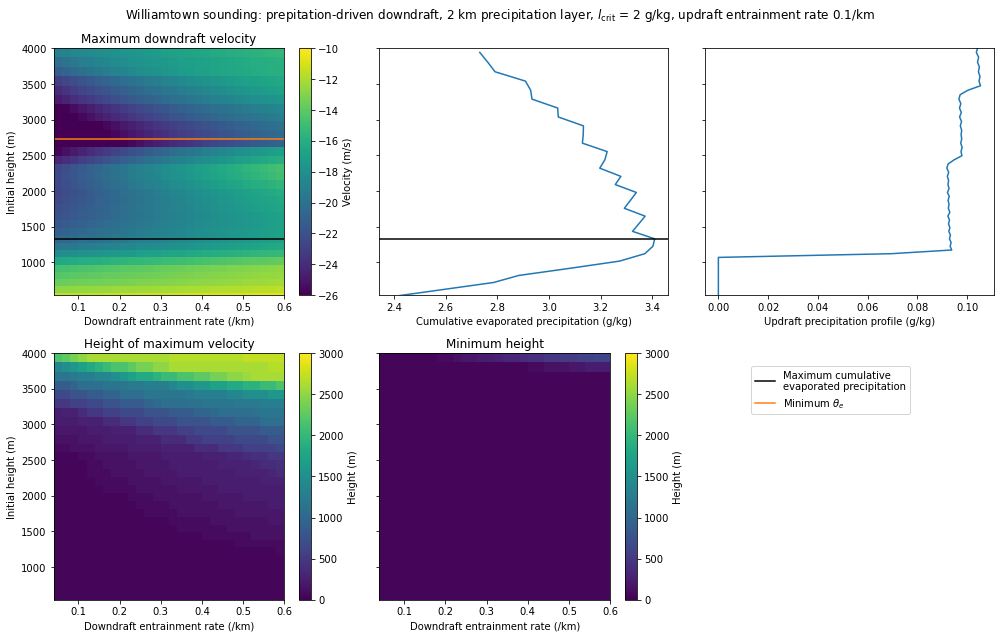

In [135]:
fig, axes = plt.subplots(2, 3, figsize=(14,9))

mesh = axes[0,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity, shading='nearest')
mesh.set_clim(-26, -10)
cbar = plt.colorbar(mesh, ax=axes[0,0])
cbar.set_label('Velocity (m/s)')
axes[0,0].axhline(max_evap_height, color='k',
                  label='Maximum cumulative\nevaporated precipitation')
axes[0,0].axhline(z_min_theta_e, color='tab:orange',
                  label='Minimum $\\theta_e$')
axes[0,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Maximum downdraft velocity')
axes[0,0].set_ylim(540, 4000)

mesh = axes[0,1].plot(total_precip*1e3, z_init_down)
axes[0,1].axhline(max_evap_height, color='k', label='Max evap.')
axes[0,1].set(xlabel='Cumulative evaporated precipitation (g/kg)', ylabel='')
axes[0,1].set_yticklabels([])
axes[0,1].set_ylim(540, 4000)

mesh = axes[0,2].plot(
    updraft.precipitation*updraft.m_remaining*1e3, height)
axes[0,2].set(xlabel='Updraft precipitation profile (g/kg)', ylabel='')
axes[0,2].set_yticklabels([])
axes[0,2].set_ylim(540, 4000)

mesh = axes[1,0].pcolormesh(
    epsilon_down, z_init_down, max_velocity_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,0])
cbar.set_label('Height (m)')
axes[1,0].set(xlabel='Downdraft entrainment rate (/km)',
              ylabel='Initial height (m)',
              title='Height of maximum velocity')
axes[1,0].set_ylim(540, 4000)

mesh = axes[1,1].pcolormesh(
    epsilon_down, z_init_down, min_height, shading='nearest')
mesh.set_clim(0, 3000)
cbar = plt.colorbar(mesh, ax=axes[1,1])
cbar.set_label('Height (m)')
axes[1,1].set(xlabel='Downdraft entrainment rate (/km)', ylabel='',
              title='Minimum height')
axes[1,1].set_yticklabels([])
axes[1,1].set_ylim(540, 4000)

axes[1,2].remove()
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.75, 0.35))

fig.suptitle('Williamtown sounding: '
             'prepitation-driven downdraft, 2 km precipitation layer, '
             '$l_\mathrm{{crit}}$ = 2 g/kg, updraft entrainment rate 0.1/km')
fig.tight_layout()